<font color=gray>Demo Notebook.
Copyright (c) 2021 Oracle, Inc.  All rights reserved.
Licensed under the Universal Permissive License v 1.0 as shown at https://oss.oracle.com/licenses/upl.
</font>

# Introduction

We are going to use a time series model to predict the number of vehicles on I-94 in Minnesota using **Statsmodels** and **Prophet** to build time series models. The code below was adopted from a demonstration notebook created by the Oracle Cloud Infrastructure Data Science Team. 

## Statsmodels

**statsmodels** is a Python module that provides classes and functions for the estimation of many different statistical models, as well as for conducting statistical tests, and statistical data exploration. An extensive list of result statistics are available for each estimator. The results are tested against existing statistical packages to ensure that they are correct. The package is released under the open source Modified BSD (3-clause) license. The online documentation is hosted at statsmodels.org and can be opened in this notebook by executing the following in a codeblock:

`statsmodels.tools.web.webdoc(func=None, stable=None)`


## Dataset

We are going to use the I-94 traffic data set, which records the number of vehicles on the road on the Interstate 94 Westbound traffic taken by the Minnesota Department of Transportation at station 301 which is approximately midway between Minneapolis and St. Paul. We are going to build a model to predict the vehicle volume at a given datetime.

In [1]:
import pandas as pd
import numpy as np
import statsmodels.api as sm
import matplotlib.pyplot as plt
import seaborn as sns
import urllib
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.preprocessing import MinMaxScaler
from math import sqrt
%matplotlib inline

In [2]:
data = pd.read_csv("../data/Metro_Interstate_Traffic_Volume_Edit.csv")

## Exploratory Data Analysis

Next we are going to explore the dataset.

In [3]:
data.head()

,holiday,temp,rain_1h,snow_1h,clouds_all,weather_main,weather_description,date_time,traffic_volume
0,None,288.28,0.0,0.0,40,Clouds,scattered clouds,2012-10-02 09:00:00,5545
1,None,289.36,0.0,0.0,75,Clouds,broken clouds,2012-10-02 10:00:00,4516
2,None,289.58,0.0,0.0,90,Clouds,overcast clouds,2012-10-02 11:00:00,4767
3,None,290.13,0.0,0.0,90,Clouds,overcast clouds,2012-10-02 12:00:00,5026
4,None,291.14,0.0,0.0,75,Clouds,broken clouds,2012-10-02 13:00:00,4918


In [4]:
max(data['date_time'])

'2018-09-30 23:00:00'

In [5]:
min(data['date_time'])

'2012-10-02 09:00:00'

The data set spans from 2012 to 2018. 

### Descriptions of the features:

1. holiday Categorical US National holidays plus regional holiday, Minnesota State Fair
2. temp Numeric Average temp in kelvin
3. rain_1h Numeric Amount in mm of rain that occurred in the hour
4. snow_1h Numeric Amount in mm of snow that occurred in the hour
5. clouds_all Numeric Percentage of cloud cover
6. weather_main Categorical Short textual description of the current weather
7. weather_description Categorical Longer textual description of the current weather
8. date_time DateTime Hour of the data collected in local CST time
9. traffic_volume Numeric Hourly I-94 ATR 301 reported westbound traffic volume

In [6]:
data['ds'] = pd.to_datetime(data["date_time"])

### Visualize Dataset

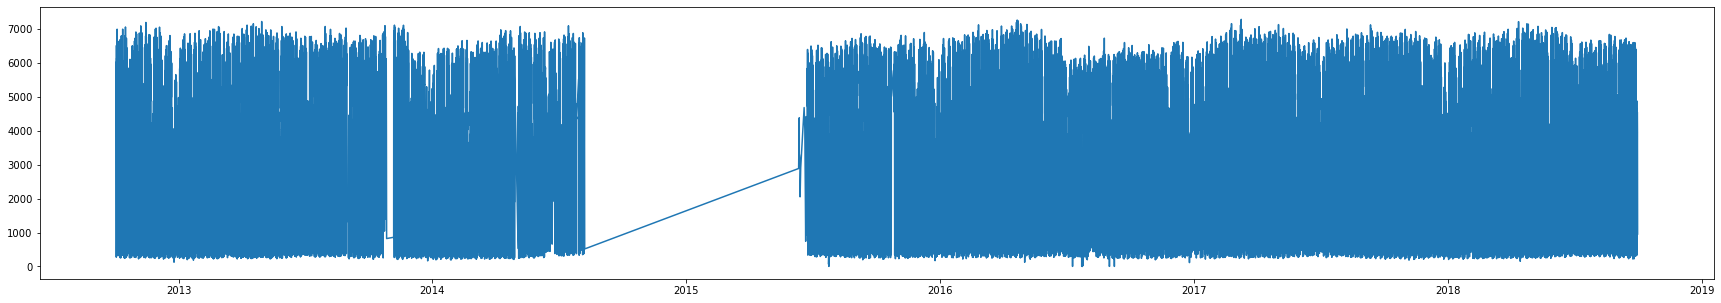

In [7]:
plt.rcParams['figure.figsize'] = [30, 5]
plt.plot(data['ds'], data['traffic_volume'])
plt.show()

#### It is a bit hard to see with so much data.  There is missing data in 2015.  Let's plot the data from just the year 2017

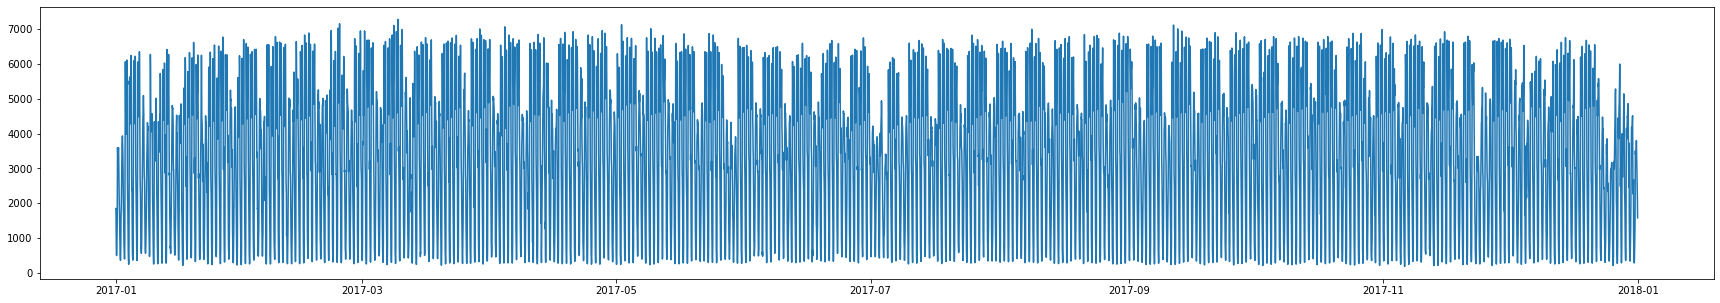

In [8]:
data_2017 = data[(data['date_time']>'2017-01-01') & (data['date_time']<'2018-01-01')]
plt.plot(data_2017['ds'], data_2017['traffic_volume'])
plt.show()

#### Let's look at the data for the month of 01/2017

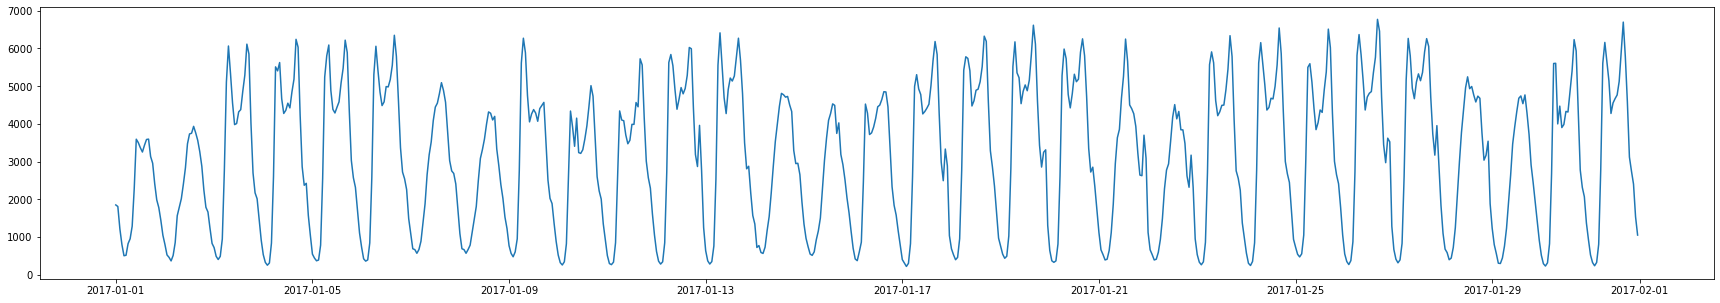

In [9]:
plt.rcParams['figure.figsize'] = [30, 5]
data_01_2017 = data[(data['date_time']>'2017-01-01') & (data['date_time']<'2017-02-01')]
plt.plot(data_01_2017['ds'], data_01_2017['traffic_volume'])
plt.show()

#### Let's look at the data for a single day

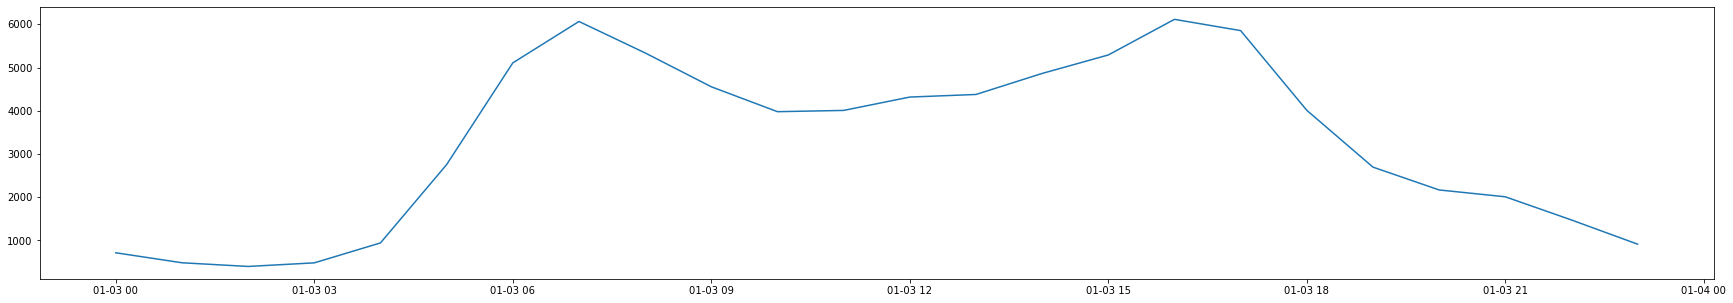

In [20]:
plt.rcParams['figure.figsize'] = [30, 5]
data_01_03_2017 = data[(data['date_time']>'2017-01-03') & (data['date_time']<'2017-01-04')]
plt.plot(data_01_03_2017['ds'], data_01_03_2017['traffic_volume'])
plt.show()

#### Exercise:  Can you plot the traffic volume of a holiday (i.e. Christmas Day 12/25, Independence Day 7/4) to see what the traffic volume is like?

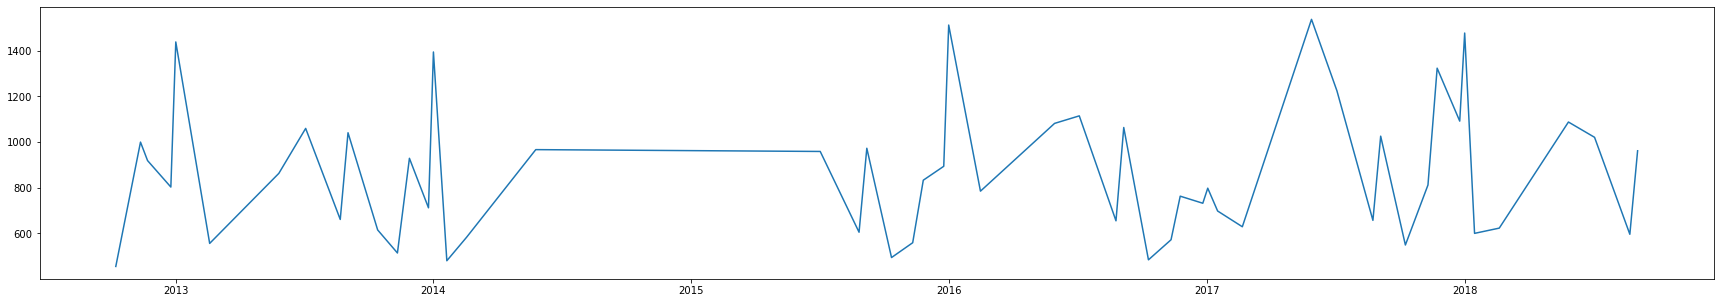

In [19]:
plt.rcParams['figure.figsize'] = [30, 5]
data_holiday = data[(data['holiday']!="None")]
plt.plot(data_holiday['ds'], data_holiday['traffic_volume'])
plt.show()

#### Let's check the number of days each type of weather is observed

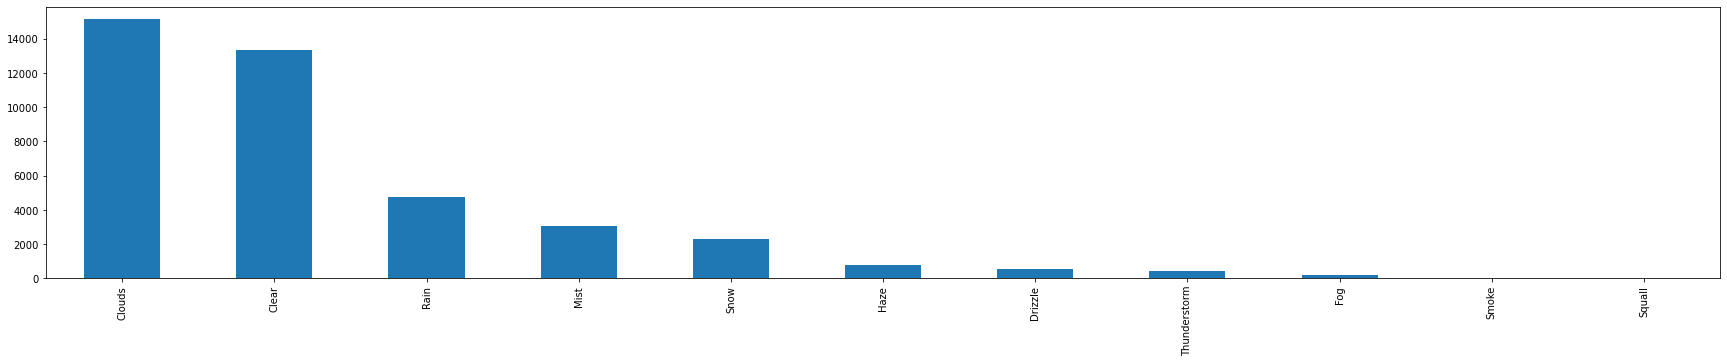

In [21]:
data["weather_main"].value_counts().plot.bar()
plt.show()

In [22]:
data['weekday'] = data.ds.dt.weekday
data['date'] = data.ds.dt.date
data['hour'] = data.ds.dt.hour
data['month'] = data.ds.dt.month
data['year'] = data.ds.dt.year


### Let's plot the traffic volume on the different days of the week
0 = Monday
6 = Sunday

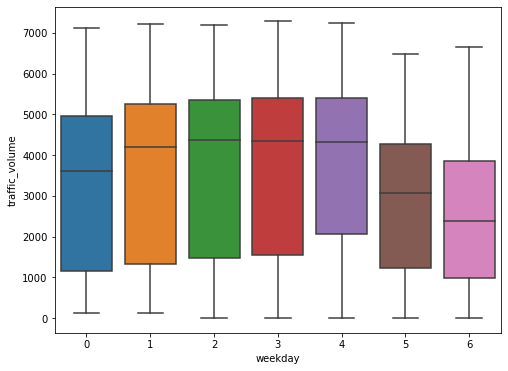

In [23]:
plt.figure(figsize=(8,6))
sns.boxplot(x='weekday', y='traffic_volume', data = data)
plt.show()

### Exercise:  Using the example codes above, can you plot the traffic volume by hours?  What types of trends do you observe?

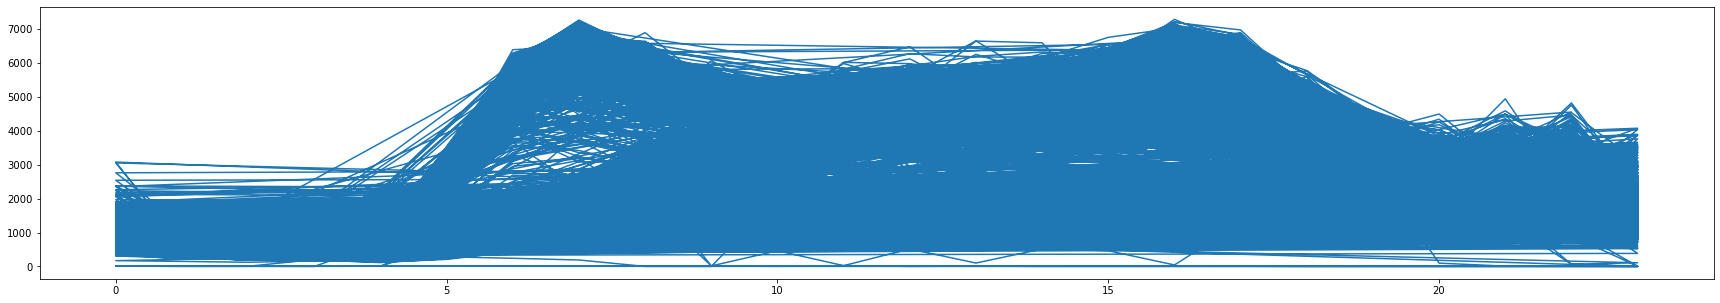

In [24]:
plt.rcParams['figure.figsize'] = [30, 5]
plt.plot(data['hour'], data['traffic_volume'])
plt.show()

### Training data and testing data

Let's use data from 7/1/17 and 7/31/18 to train the model.  We will use the model to predict the hourly vehicle volume for 8/1/18 - 8/31/18.  

In [74]:
data_subset = data[(data['date_time']>'2017-07-01') & (data['date_time']<'2018-08-01')]
data_subset = data_subset.reset_index(drop = True)

In [75]:
data_test = data[(data['date_time']>'2018-08-01') & (data['date_time']<'2018-09-01')]


### Test stationarity of Time Series
A time series is stationary if the statistical properties of the process does not change over time.  For example, the mean and variance are constant over time.  We are going to check if our time series is stationary.  It is often necessary to test for stationarity in time series data because many useful statistical tests and models depend on it.  We are going to use the Augmented Dickey-Fuller test to determine whether the dataset is stationary or not.  The Augmented Dickey-Fuller test tests the null hypothesis that the time series process is not stationary. If the p-value of the test falls below a threshhold value (usually 0.05), then the null hypothesis can be rejected and the data set is stationary.  

We are going to use the open source package Statsmodels to perform the Augmented Dickey-Fuller test.  Statsmodels is one of the pacakges that is a part of the General Machine Learning for CPU conda.

For more information about stationarity of a time series, please visit this [link](https://www.kdnuggets.com/2019/08/stationarity-time-series-data.html)

You can find out more about Statsmodels from the [documentation](https://www.statsmodels.org/stable/index.html)



In [79]:
from statsmodels.tsa.stattools import adfuller
X = data_subset['traffic_volume'].values
result = adfuller(X)
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])
print('Critical Values:')
for key, value in result[4].items():
    print('\t%s: %.3f' % (key, value))

ADF Statistic: -11.735330
p-value: 0.000000
Critical Values:
	1%: -3.431
	5%: -2.862
	10%: -2.567


Because the p-value is much less than 0.05, we can reject the null hypothesis and the time series data is stationary.

We can also plot the moving average and moving standard deviation over the training data to check.

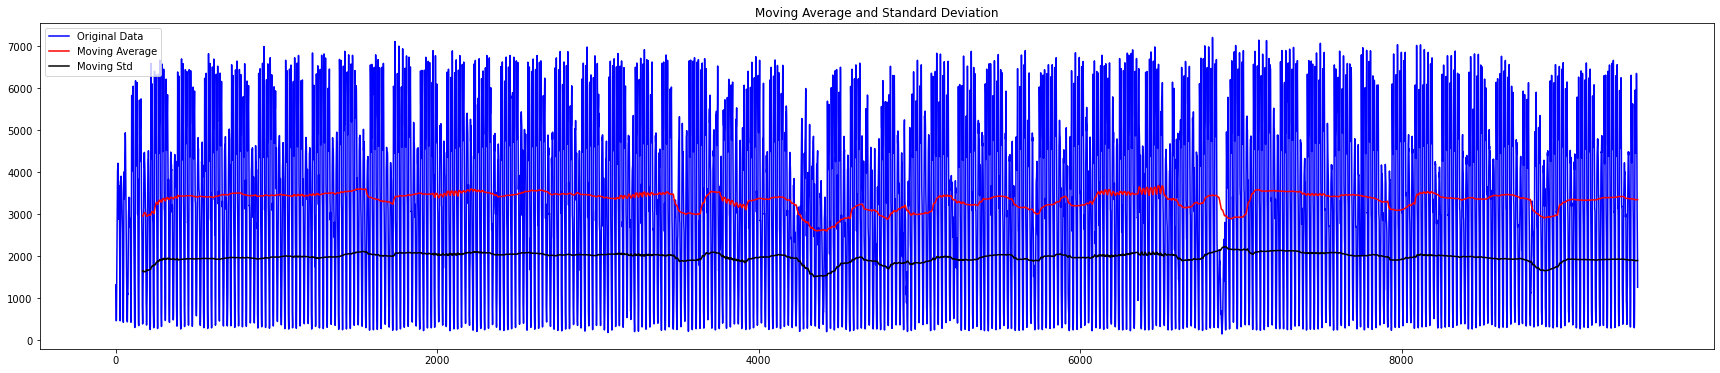

In [53]:
#Plot moving average and moving standard deviation
plt.figure(figsize=(30,6))
orig = plt.plot(X, color='blue',label='Original Data')
moving_avg = data_subset['traffic_volume'].rolling(168).mean()
moving_std = data_subset['traffic_volume'].rolling(168).std()
plt.plot(moving_avg, color='red', label='Moving Average')
plt.plot(moving_std, color='black', label = 'Moving Std')
plt.legend(loc='best')
plt.title('Moving Average and Standard Deviation')
plt.show(block=False)

## ARIMA modeling

ARIMA is a a type of time series forecasting model. It is an acroynm that stands for AutoRegressive Integrated Moving Average. There are three parameters of the model p, d, q. The parameters are defined as follow:

p: auto regressive parameter
d: degree of differencing
q: order of moving average

To determine the parameters of the model, we will use the autocorrelation and partial autocorrelation plots.  You can read more about these plots [here](https://machinelearningmastery.com/gentle-introduction-autocorrelation-partial-autocorrelation/)

In [66]:
training_data_arima = data_subset[['ds', 'traffic_volume']]
testing_data_arima = data_test[['ds', 'traffic_volume']]
training_data_arima.set_index('ds', inplace = True)
testing_data_arima.set_index('ds', inplace = True)


In [67]:
training_data_arima.index = pd.DatetimeIndex(training_data_arima.index).to_period('H')
testing_data_arima.index = pd.DatetimeIndex(testing_data_arima.index).to_period('H')

In [68]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.stattools import acf, pacf
from statsmodels.tsa.arima_model import ARIMA

### Look at the partial autocorrelation plot (pacf) and  autocorrelation (acf) plot

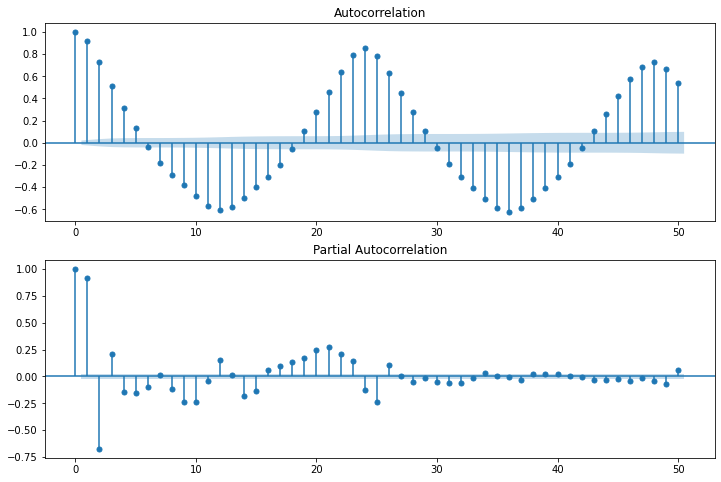

In [69]:
fig = plt.figure(figsize=(12,8))
ax1 = fig.add_subplot(211)
fig = sm.graphics.tsa.plot_acf(training_data_arima['traffic_volume'], lags=50, ax=ax1) 
ax2 = fig.add_subplot(212)
fig = sm.graphics.tsa.plot_pacf(training_data_arima['traffic_volume'], lags=50, ax=ax2)

We are going to get the autoregression term p from the partial autocorrelation plot.  From it, it looks like within 2 lags, the autoregression is significant.  We will set the term = 2. 

Since the data is stationary, we are going to set differencing term to 0.

We are going to get the moving average term or q from looking at the autocorrelation plot.   From the plot, we will set the MA term to be 6.


In [70]:
p= 2
d = 0
q = 6

In [71]:
arima_model = ARIMA(training_data_arima, order=(p,d,q)).fit()

c:\Users\carso\anaconda3\lib\site-packages\statsmodels\tsa\arima_model.py:472: FutureWarning: 
statsmodels.tsa.arima_model.ARMA and statsmodels.tsa.arima_model.ARIMA have
been deprecated in favor of statsmodels.tsa.arima.model.ARIMA (note the .
between arima and model) and
statsmodels.tsa.SARIMAX. These will be removed after the 0.12 release.

statsmodels.tsa.arima.model.ARIMA makes use of the statespace framework and
is both well tested and maintained.

To silence this warning and continue using ARMA and ARIMA until they are
removed, use:

import warnings
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARMA',
                        FutureWarning)
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARIMA',
                        FutureWarning)

  warnings.warn(ARIMA_DEPRECATION_WARN, FutureWarning)


In [72]:
print(arima_model.summary())

                              ARMA Model Results                              
Dep. Variable:         traffic_volume   No. Observations:                 9470
Model:                     ARMA(2, 6)   Log Likelihood              -72633.875
Method:                       css-mle   S.D. of innovations            518.313
Date:                Wed, 22 Nov 2023   AIC                         145287.749
Time:                        09:15:37   BIC                         145359.308
Sample:                    07-01-2017   HQIC                        145312.037
                         - 07-31-2018                                         
                           coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------------
const                 3340.4555     24.965    133.806      0.000    3291.525    3389.386
ar.L1.traffic_volume     1.9308      0.000   6146.634      0.000       1.930       1.931
ar.L2.traffi

### Model Performance

We are going to use the fitted model to predict the vehicle volume in the test time range.

We are going to look at the mean absolute error, root mean squared error and mean absolute percentage error of the predicted value for the testing time range vs the actual values.  



In [36]:
predictions = arima_model.forecast(steps= 24*31)[0]
rng = pd.date_range('8/1/2018 00:00', periods=744, freq='1H')
prediction_df =pd.DataFrame(predictions, index = rng, columns = ['predicted_vehicle_volume'])


In [37]:
prediction_df.index = pd.DatetimeIndex(prediction_df.index).to_period('H')

In [38]:
result_df = pd.merge(prediction_df, testing_data_arima, left_index=True, right_index=True)

In [39]:
def mean_absolute_percentage_error(y_true, y_pred): 
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

mae_arima = mean_absolute_error(result_df['traffic_volume'], result_df['predicted_vehicle_volume'])
rmse_arima = np.sqrt(mean_squared_error(result_df['traffic_volume'], result_df['predicted_vehicle_volume']))
mape_arima = mean_absolute_percentage_error(result_df['traffic_volume'], result_df['predicted_vehicle_volume'])

## Measuring Model Fit
Several metrics can be referenced to evaluate how accurate our predictions are and, what is the amount of deviation from the actual values. 

**Root Mean Squared Error (RMSE)** is the Root of the Mean of the Square of Errors. With any model there will exist some differences between predicted and actual data points. These differences are known as residuals and commonly called error. Scikit-learn includes a metrics library that can be called upon to calculate these values.

**Mean Absolute Error (MAE)** measures the differences between the predicted values (values predicted by our regression model) and the actual values of a variable.

In [40]:
print('Test Mean Absolute Error:', mae_arima)
print('Test Root Mean Squared Error:', rmse_arima)
print('Test Mean Absolute percentage Error:', mape_arima)

Test Mean Absolute Error: 1031.822025100462
Test Root Mean Squared Error: 1263.9225473436088
Test Mean Absolute percentage Error: 81.09726068513065


You can further tune the parameters and perhaps add in seasonality (SARIMA) to improve the performance.

### Challenge Problem \#11:  

Add an additional variable [whether it rained or not]  and see the impact to the model?  First you will have to create a new column to both the training and test data set on whether it rained or not.  Then, you will have to create a new model and add that regressor to it.  Finally, fit the model and get a new forecast. 

Submit the code you write to complete the steps above as text on Canvas and discuss the changes in the model forecast relative to the baseline. Submissions will be accepted through 11:59pm on 5/5/2023.

In [81]:
data_subset = data[(data['date_time']>'2017-07-01') & (data['date_time']<'2018-08-01')]
data_subset = data_subset.reset_index(drop = True)
data_subset["rain"] = (data_subset["weather_main"] == "Rain").astype(int)
#data_subset

data_test = data[(data['date_time']>'2018-08-01') & (data['date_time']<'2018-09-01')]
data_test = data_test.reset_index(drop = True)
data_test["rain"] = (data_test["weather_main"] == "Rain").astype(int)
#data_test

In [88]:
training_data_arima = data_subset[['ds','rain', 'traffic_volume']]
testing_data_arima = data_test[['ds','rain', 'traffic_volume']]
training_data_arima.set_index('ds', inplace = True)
testing_data_arima.set_index('ds', inplace = True)
training_data_arima.index = pd.DatetimeIndex(training_data_arima.index).to_period('H')
testing_data_arima.index = pd.DatetimeIndex(testing_data_arima.index).to_period('H')

In [93]:
p= 2
d = 0
q = 6
endog = training_data_arima['traffic_volume']
endog_diff = endog.diff().dropna()
exog = training_data_arima[['rain']]
arima_model = ARIMA(endog_diff, order=(p,d,q), exog=exog[1:]).fit()

c:\Users\carso\anaconda3\lib\site-packages\statsmodels\tsa\arima_model.py:472: FutureWarning: 
statsmodels.tsa.arima_model.ARMA and statsmodels.tsa.arima_model.ARIMA have
been deprecated in favor of statsmodels.tsa.arima.model.ARIMA (note the .
between arima and model) and
statsmodels.tsa.SARIMAX. These will be removed after the 0.12 release.

statsmodels.tsa.arima.model.ARIMA makes use of the statespace framework and
is both well tested and maintained.

To silence this warning and continue using ARMA and ARIMA until they are
removed, use:

import warnings
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARMA',
                        FutureWarning)
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARIMA',
                        FutureWarning)

  warnings.warn(ARIMA_DEPRECATION_WARN, FutureWarning)
c:\Users\carso\anaconda3\lib\site-packages\statsmodels\base\model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warn

In [94]:
print(arima_model.summary())

                              ARMA Model Results                              
Dep. Variable:         traffic_volume   No. Observations:                 9469
Model:                     ARMA(2, 6)   Log Likelihood              -73630.943
Method:                       css-mle   S.D. of innovations            576.268
Date:                Wed, 22 Nov 2023   AIC                         147283.887
Time:                        09:28:51   BIC                         147362.600
Sample:                    07-01-2017   HQIC                        147310.603
                         - 07-31-2018                                         
                           coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------------
const                   -0.0059      0.040     -0.147      0.883      -0.085       0.073
rain                    -0.0364      0.595     -0.061      0.951      -1.203       1.130
ar.L1.traffi

In [120]:
exog_test = testing_data_arima[['rain']]
predictions = arima_model.forecast(steps= 740, exog=exog_test)[0]
rng = pd.date_range('8/1/2018 00:00', periods=740, freq='1H')
prediction_df =pd.DataFrame(predictions, index = rng, columns = ['predicted_vehicle_volume'])

prediction_df.index = pd.DatetimeIndex(prediction_df.index).to_period('H')

result_df = pd.merge(prediction_df, testing_data_arima, left_index=True, right_index=True)

def mean_absolute_percentage_error(y_true, y_pred): 
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

mae_arima = mean_absolute_error(result_df['traffic_volume'], result_df['predicted_vehicle_volume'])
rmse_arima = np.sqrt(mean_squared_error(result_df['traffic_volume'], result_df['predicted_vehicle_volume']))
mape_arima = mean_absolute_percentage_error(result_df['traffic_volume'], result_df['predicted_vehicle_volume'])

In [121]:
print('Test Mean Absolute Error:', mae_arima)
print('Test Root Mean Squared Error:', rmse_arima)
print('Test Mean Absolute percentage Error:', mape_arima)

Test Mean Absolute Error: 3437.58090000128
Test Root Mean Squared Error: 3957.476818504118
Test Mean Absolute percentage Error: 99.62898517782435


Without the new Variable:
Test Mean Absolute Error: 1031.822025100462
Test Root Mean Squared Error: 1263.9225473436088
Test Mean Absolute percentage Error: 81.09726068513065

With the new Variable:
Test Mean Absolute Error: 3437.58090000128
Test Root Mean Squared Error: 3957.476818504118
Test Mean Absolute percentage Error: 99.62898517782435

It appears that the addition of the 'rain' variable to the model has resulted in significant changes in the model's performance metrics. The Mean absolute error has increased a lot when considering the 'rain' variable, which means that the predictions are, on average, further from the actual values. The Root Mean Squared Error has also increased a lot, which suggests a higher level of deviation between predicted and actual values.